Sales Forecasting
#2. Univariate modeling
## 2-3. ARIMA

In [ ]:
# !pip install pmdarima

In [ ]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [ ]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [ ]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [ ]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [ ]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [ ]:
train_df = plot_by_family(train, 44, [TARGET], True)

## 1) Test of Stationarity (정상성 확인)

* 참고사이트: https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

In [ ]:
lag = 50

* ACF는 천천히 감소하는 형태
* Augmented Dickey-Fuller(ADF) Test 결과는 p-value가 0.05보다 작아 귀무가설 기각하여 정상성을 만족한다 볼 수 있음
  - H0: 정상성 만족하지 않음 vs. H1: 정상정 만족

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



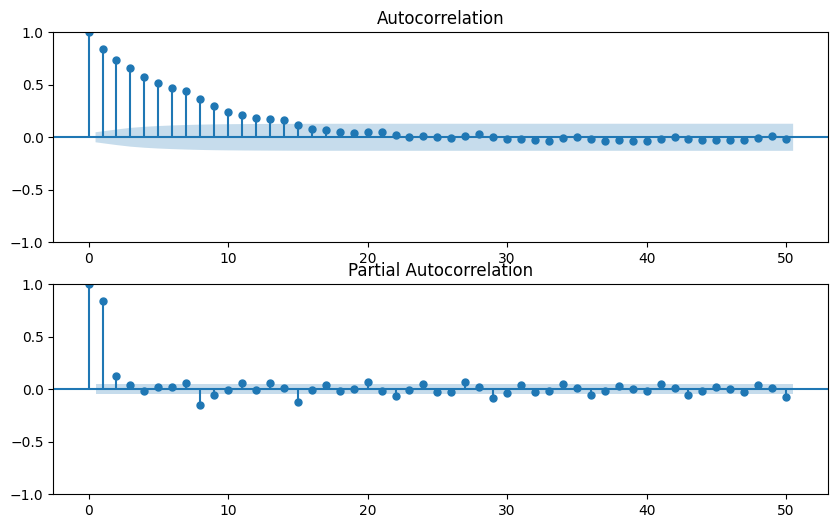

In [ ]:
fig = plt.Figure(figsize = (10, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(train_df[TARGET], lags=lag, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(train_df[TARGET], lags=lag, ax=ax2)

In [ ]:
adf_test = adfuller(train_df[TARGET])

In [ ]:
print(f'statistics: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

statistics: -7.1347754018087
p-value: 3.4436854295251395e-10


* 계절 차분 하여 정상성을 만족하는지 확인
* 계절 차분했을 때 ACF 기준 수렴이 더욱 빠름을 확인, ADF test도 유의
* 다만 ACF를 보았을 때 lag 7 단위로 spike가 보여 추가적인 계절성이 있을것으로 판단

In [ ]:
s = 365
diff = train_df[TARGET] - train_df[TARGET].shift(s)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



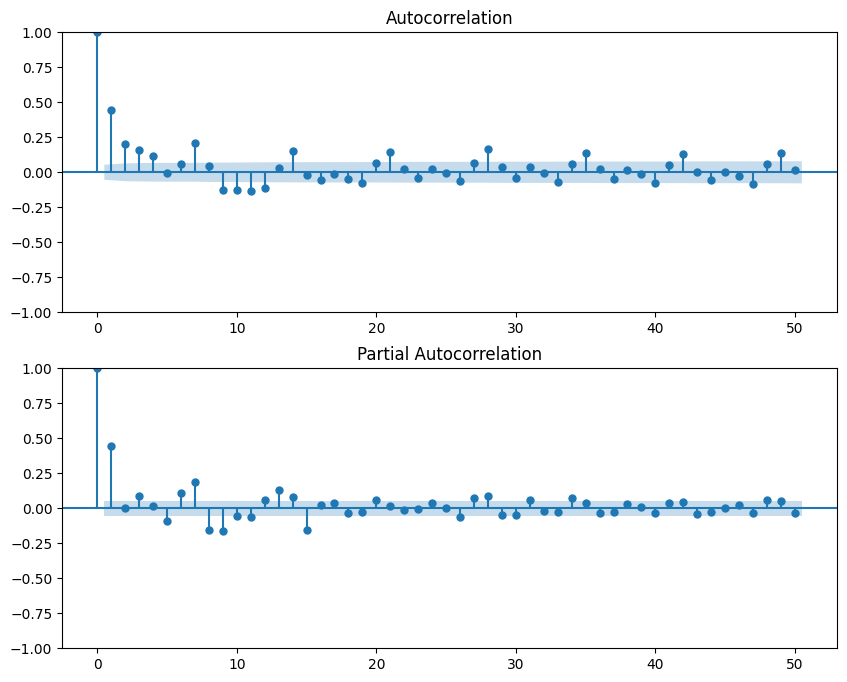

In [ ]:
fig = plt.Figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(diff[s:], lags=lag, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(diff[s:], lags=lag, ax=ax2)

In [ ]:
diff_adf_test = adfuller(diff[s:])
print(f'statistics: {diff_adf_test[0]}')
print(f'p-value: {diff_adf_test[1]}')

statistics: -9.292077402152923
p-value: 1.1724331853026175e-15


## 2) ARIMA Fitting

In [ ]:
valid_ratio = 0.7

In [ ]:
train_period = int(train_df.shape[0]*valid_ratio)
trains = train_df.iloc[:train_period]
valids = train_df.iloc[train_period:]

trains.shape, valids.shape

((1178, 2), (506, 2))

In [ ]:
model = pm.auto_arima(trains[TARGET], seasonal=True, m=7) # quaterly: m=4, monthly: m=12

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1178
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -8654.952
Date:                             Sun, 11 Jun 2023   AIC                          17319.905
Time:                                     08:43:57   BIC                          17345.262
Sample:                                          0   HQIC                         17329.465
                                            - 1178                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7073      0.007     94.647      0.000       0.693       0.722
ar.L2          0.1543      0.007     22.859      0.000       0.141       0.168
ar.S.L7        0.9835      0.011     92.772      0.000       0.963       1.004
ma.S.L7       -0.9227      0.021    -44.964      0.000      -0.963      -0.882
sigma2      1.404e+05    841.758    166.739      0.000    1.39e+05    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            562974.61
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                             5.87
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
preds = model.predict(valids.shape[0])

<Axes: >

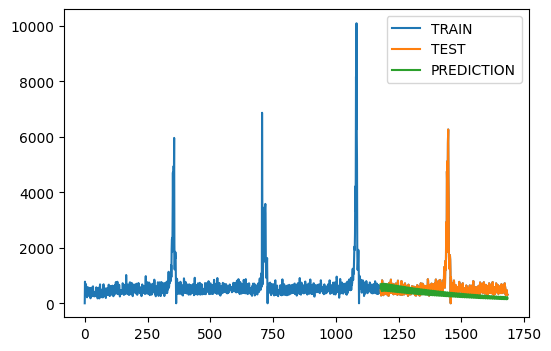

In [ ]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds.plot(legend=True, label='PREDICTION')

* auto-arima 모형이 seasonality를 7로 설정하여 짧은 계절성은 대체로 예측하려 하지만 연단위 계절성을 전혀 잡지못하는 문제가 있음

<Axes: >

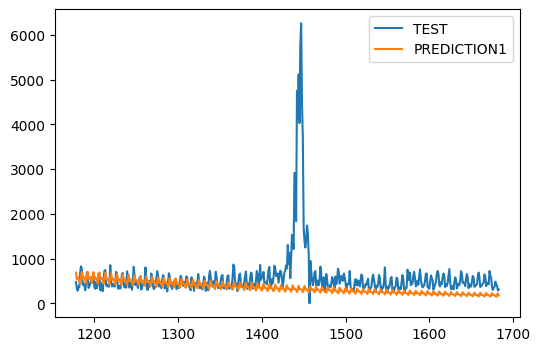

In [ ]:
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
preds.plot(legend=True, label='PREDICTION1')

## 3) SARIMA (Seasonality 추가)

* 연단위 seasonalty를 고려하기 위해 sarima 모형을 적합하고자 하지만 학습 시간이 굉장히 오래걸림

In [ ]:
sarima_model = SARIMAX(trains[TARGET], order=(2, 0, 0), seasonal_order=(0, 7, 1, s))
sarima_model_fitted = sarima_model.fit(maxiter=50)

In [ ]:
sarima_model_fitted.summary()

In [ ]:
sarima_preds = sarima_model_fitted.forecast(steps=valids.shape[0])

In [ ]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids[TARGET].plot(legend=True, label='TEST',figsize=(6,4))
sarima_preds.plot(legend=True, label='PREDICTION')

In [ ]:
sarima_preds.plot(legend=True, label='PREDICTION')